In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

**Load Data**

In [5]:
import os

model_dir = 'FACTOR_MODEL'
print(os.listdir(model_dir))

['covariance.2003.pickle.bz2', 'covariance.2004.pickle.bz2', 'covariance.2005.pickle.bz2', 'covariance.2006.pickle.bz2', 'covariance.2007.pickle.bz2', 'covariance.2008.pickle.bz2', 'covariance.2009.pickle.bz2', 'covariance.2010.pickle.bz2', 'pandas-frames.2003.pickle.bz2', 'pandas-frames.2004.pickle.bz2', 'pandas-frames.2005.pickle.bz2', 'pandas-frames.2006.pickle.bz2', 'pandas-frames.2007.pickle.bz2', 'pandas-frames.2008.pickle.bz2', 'pandas-frames.2009.pickle.bz2', 'pandas-frames.2010.pickle.bz2']


In [6]:
model_dir = 'FACTOR_MODEL'

def sort_cols(test):
    return test.reindex(sorted(test.columns), axis=1)

frames = {}
for year in [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]:
    fil = model_dir + "/pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pd.read_pickle(fil))

for x in frames:
    frames[x] = sort_cols(frames[x])

covariance = {}
for year in [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]:
    fil = model_dir + "/covariance." + str(year) + ".pickle.bz2"
    covariance.update(pd.read_pickle(fil))




In [7]:
covariance["20040102"]['Factor1'].unique()

array(['1DREVRSL', 'BETA', 'DIVYILD', 'DWNRISK', 'EARNQLTY', 'EARNYILD',
       'GROWTH', 'INDMOM', 'LEVERAGE', 'LIQUIDTY', 'LTREVRSL', 'MGMTQLTY',
       'MIDCAP', 'MOMENTUM', 'PROFIT', 'PROSPECT', 'RESVOL', 'SEASON',
       'SENTMT', 'STREVRSL', 'SIZE', 'VALUE', 'OILGSDRL', 'OILGSEQP',
       'OILGSEXP', 'OILGSCON', 'CHEM', 'SPTYCHEM', 'CNSTMATL', 'CONTAINR',
       'PAPER', 'ALUMSTEL', 'PRECMTLS', 'AERODEF', 'CNSTMACH', 'INDMACH',
       'BLDGPROD', 'TRADECO', 'CNSTENG', 'ELECEQP', 'CONGLOM', 'COMSVCS',
       'AIRLINES', 'TRANSPRT', 'ROADRAIL', 'AUTO', 'HOUSEDUR', 'HOMEBLDG',
       'LEISPROD', 'LEISSVCS', 'RESTAUR', 'MEDIA', 'DISTRIB', 'APPAREL',
       'SPTYSTOR', 'SPLTYRET', 'PSNLPROD', 'FOODRET', 'FOODPROD',
       'BEVTOB', 'HLTHEQP', 'MGDHLTH', 'HLTHSVCS', 'BIOLIFE', 'PHARMA',
       'BANKS', 'DIVFIN', 'LIFEINS', 'INSURNCE', 'REALEST', 'SEMIEQP',
       'SEMICOND', 'INTERNET', 'SOFTWARE', 'COMMEQP', 'COMPELEC',
       'TELECOM', 'WIRELESS', 'ELECUTIL', 'GASUTIL', 'MULTUTIL'],

In [8]:
frames["20040102"][[
  'STREVRSL', 'LTREVRSL', 'INDMOM',
  'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']]

,STREVRSL,LTREVRSL,INDMOM,EARNQLTY,EARNYILD,MGMTQLTY,PROFIT,SEASON,SENTMT
0,0.548,0.025,-0.300,0.183,-0.298,-1.125,-0.371,1.526,-0.922
1,0.986,-3.058,-0.178,0.532,0.558,0.402,0.790,-1.535,0.292
2,-0.256,-0.082,0.936,-0.215,2.187,0.008,0.711,0.120,-0.660
3,1.841,-0.020,0.070,-0.189,-0.259,0.068,-0.466,0.259,-0.353
4,-0.588,-0.241,-0.044,-0.717,2.621,-0.370,-1.055,1.593,-0.526
...,...,...,...,...,...,...,...,...,...
12430,0.430,-0.347,1.497,-1.089,0.078,-2.816,-0.602,0.733,-0.251
12431,0.561,-0.323,1.495,-1.089,0.091,-2.816,-0.602,1.234,-0.251
12432,0.734,-0.289,1.496,-1.089,1.108,-2.816,-0.602,0.790,-0.251
12433,0.680,-0.587,1.502,-0.650,0.023,-2.816,-0.602,1.067,-0.251


**Data Cleaning and Winsorization**

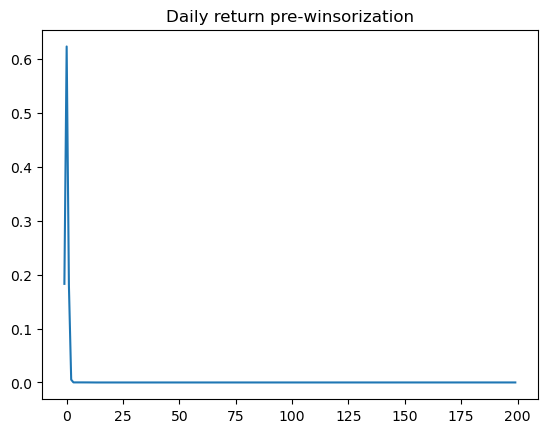

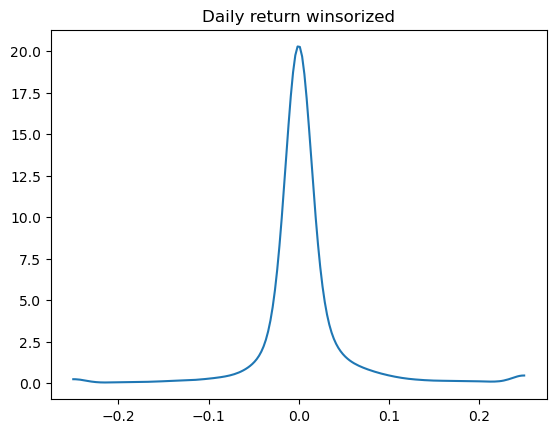

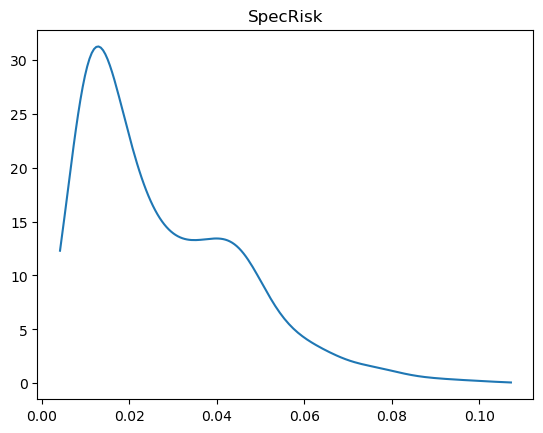

In [10]:
def wins(x, a, b):
    return np.where(x <= a, a, np.where(x >= b, b, x))

def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    return df


def density_plot(data, title):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 200)
    density.covariance_factor = lambda: 0.25
    density._compute_covariance()
    plt.plot(xs, density(xs))
    plt.title(title)
    plt.show()

test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'], -0.25, 0.25), 'Daily return winsorized')
density_plot(test['SpecRisk'] / (100 * math.sqrt(252)), 'SpecRisk')


Many of the remaining columns are industry factors, of which a full list is given below.

In [14]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO', 'BANKS', 'BEVTOB', 'BIOLIFE',
                    'BLDGPROD', 'CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
                    'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB', 'DIVFIN', 'ELECEQP', 'ELECUTIL',
                    'FOODPROD', 'FOODRET', 'GASUTIL', 'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR',
                    'INDMACH', 'INSURNCE', 'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH',
                    'MULTUTIL', 'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
                    'PRECMTLS', 'PSNLPROD', 'REALEST', 'RESTAUR', 'ROADRAIL', 'SEMICOND', 'SEMIEQP',
                    'SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA', 'SIZE', 'MOMENTUM', 'VALUE']

def get_formula(alpha):
    L = ["0", alpha]
    L.extend(style_factors)
    L.extend(industry_factors)
    return "Ret ~ " + " + ".join(L)


In [15]:
def get_estu(df):
  """Estimation universe definition"""
  estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  return estu
def colnames(X):
  """ return names of columns, for DataFrame or DesignMatrix """
  if(type(X) == patsy.design_info.DesignMatrix):
    return(X.design_info.column_names)
  if(type(X) == pd.core.frame.DataFrame):
    return(X.columns.tolist())
  return(None)

def diagonal_factor_cov(date, X):
  """Factor covariance matrix, ignoring off-diagonal for simplicity"""
  cv = covariance[date]
  k = np.shape(X)[1]
  Fm = np.zeros([k,k])
  for j in range(0,k):
    fac = colnames(X)[j]
    Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return(Fm)
def risk_exposures(estu):
  """Exposure matrix for risk factors, usually called X in class"""
  L = ["0"]
  L.extend(style_factors)
  L.extend(industry_factors)
  my_formula = " + ".join(L)
  return patsy.dmatrix(my_formula, data = estu)

In [16]:
my_date = '20040102'
# estu = estimation universe
estu = get_estu(frames[my_date])
estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)
X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

candidate_alphas = [
  'STREVRSL', 'LTREVRSL', 'INDMOM',
  'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

# **Problem 0**

In [18]:
for date, df in frames.items():
    frames[date] = get_estu(df)

# **Problem 1**

In [20]:
import numpy as np
from scipy.linalg import pinv
import patsy
import pandas as pd

def wins(x, a, b):
    return np.where(x <= a, a, np.where(x >= b, b, x))

def calculate_residuals(df):
    df['Ret'] = wins(df['Ret'], -0.25, 0.25)
    X = np.asarray(risk_exposures(df))
    X_pseudo = pinv(X)
    df['Y'] = df['Ret'] - X @ (X_pseudo @ df['Ret'])
    return df

for date, df in frames.items():
    frames[date] = calculate_residuals(df)

# **Problem 2**

In [22]:
from sklearn.model_selection import train_test_split

all_dates = list(frames.keys())
train_dates, test_dates = train_test_split(all_dates, test_size=0.2, random_state=42)
train_frames = {date: frames[date] for date in train_dates}
test_frames = {date: frames[date] for date in test_dates}

In [23]:
train_panel = pd.concat(train_frames.values(), axis=0)
test_panel = pd.concat(test_frames.values(), axis=0)

X_train = train_panel[candidate_alphas]
y_train = train_panel['Y']
X_test = test_panel[candidate_alphas]
y_test = test_panel['Y']

In [24]:
train_panel.shape

(4040726, 95)

In [25]:
X_train.head()

,STREVRSL,LTREVRSL,INDMOM,EARNQLTY,EARNYILD,MGMTQLTY,PROFIT,SEASON,SENTMT
0,-0.549,0.009,-0.547,0.026,-0.077,0.323,-0.370,0.871,-0.988
1,-2.188,-3.039,0.093,0.488,0.605,0.390,0.792,-1.562,0.083
3,1.219,-0.049,0.045,-0.146,-0.259,0.019,-0.479,0.156,-0.357
6,-0.233,1.199,0.787,-0.421,-1.082,-0.855,-1.062,0.925,-1.675
8,-0.164,0.300,-1.948,-2.511,2.587,0.122,0.104,-0.248,-0.782


In [26]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

lasso = LassoCV(alphas=np.logspace(-10, 2, 100), cv=5, random_state=42).fit(X_train, y_train)

lasso_train_pred = lasso.predict(X_train)
lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)

lasso_test_pred = lasso.predict(X_test)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)

print("Best alpha (regularization strength):", lasso.alpha_)
print("Coefficients:", lasso.coef_)
print("Train MSE:", lasso_train_mse)
print("Test MSE:", lasso_test_mse)

Best alpha (regularization strength): 1e-06
Coefficients: [ 3.75011587e-04 -1.21300155e-05  1.05717116e-04 -1.60681914e-05
  2.48478203e-05  4.55556553e-05  3.54487500e-05  5.41933245e-05
  7.29969053e-05]
Train MSE: 0.0004246235543223156
Test MSE: 0.0004348777299295715


In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=np.linspace(0.1, 15, 5), scoring='neg_mean_squared_error', cv=5)
model = make_pipeline(PolynomialFeatures(2), ridge_cv)
model.fit(X_train, y_train)
model_train_mse = -model.named_steps['ridgecv'].best_score_
model_test_mse = mean_squared_error(y_test, model.predict(X_test))
print("Best alpha (regularization strength):", model.named_steps['ridgecv'].alpha_)
print("Coefficients:", model.named_steps['ridgecv'].coef_)
print("Train MSE:", model_train_mse)
print("Test MSE:", model_test_mse)

Best alpha (regularization strength): 15.0
Coefficients: [ 0.00000000e+00  4.02610052e-04 -2.60587830e-05  8.10851433e-05
 -4.13145836e-05  5.13312567e-06  1.85958102e-05  2.39047992e-05
  7.75951434e-05  1.01902677e-04  4.18386393e-05 -2.00657540e-05
  1.71580560e-05  4.04726944e-05  5.27163186e-05  2.36266438e-05
 -4.03383357e-05  1.05453294e-05 -6.31898211e-05 -8.65268478e-06
 -1.42525807e-05 -1.37432536e-05  4.78833494e-06 -1.85941572e-05
  5.56226595e-06 -3.59257085e-07  8.83404769e-06 -5.10455221e-06
 -5.02274463e-05 -8.86531649e-06  1.09638142e-05 -1.79918780e-05
 -1.34625394e-05  2.43987311e-06  3.90205967e-06 -1.07645012e-05
 -2.71067332e-05 -2.77179982e-05  2.49870269e-05  3.16227440e-06
 -8.52912677e-06  9.74669375e-07  9.85490514e-06  3.04278814e-05
  1.87486835e-05 -6.92620530e-06 -5.49163974e-06  8.14237144e-06
 -2.60374160e-07  1.48549469e-06  1.78119280e-05  1.71450752e-05
  4.01266712e-06 -2.04739617e-05 -2.71717864e-05]
Train MSE: 0.0004246270399506145
Test MSE: 0.000

# **Problem 3**

In [29]:
def portfolio_weights(X, F, D, alpha, kappa, epsilon=1e-8):
    
    D_inv = np.diag(1 / (D + epsilon))
    F_reg = F + epsilon * np.eye(F.shape[0])
    F_inv = np.linalg.inv(F_reg)
    
    X_t = X.T
    middle_term = np.linalg.inv(F_inv + X.T @ D_inv @ X)
    gamma = middle_term @ X.T @ D_inv @ alpha
    weights = D_inv @ (alpha - X @ gamma)
    weights = weights - kappa * weights
    return weights

# **Problem 4**

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def backtest(frames, lasso_model,kappa):
    cumulative_profit = []
    long_market_values = []
    short_market_values = []
    daily_risks = []
    idiosyncratic_risks = []

    for date, df in frames.items():

        estu = get_estu(df)
        estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

        X_alpha = estu[candidate_alphas]
        alpha = lasso_model.predict(X_alpha)

        X = risk_exposures(estu)
        F = diagonal_factor_cov(date, X)
        D = (estu['SpecRisk'] / (100 * np.sqrt(252))) ** 2

        weights = portfolio_weights(X, F, D, alpha, kappa)

        profit = np.dot(weights, estu['Ret'])
        cumulative_profit.append(profit)

        long_market_value = np.sum(weights[weights > 0])
        short_market_value = np.sum(np.abs(weights[weights < 0]))
        long_market_values.append(long_market_value)
        short_market_values.append(short_market_value)

        # Risk Analysis
        risk = np.sqrt(weights.T @ (X @ F @ X.T + np.diag(D)) @ weights)
        idio_risk = weights @ np.diag(D) @ weights
        daily_risks.append(risk)
        idiosyncratic_risks.append(idio_risk / risk)

    results = {
        "cumulative_profit": np.cumsum(cumulative_profit),
        "long_market_values": long_market_values,
        "short_market_values": short_market_values,
        "daily_risks": daily_risks,
        "idiosyncratic_risks": idiosyncratic_risks,
    }
    return results


results = backtest(frames, lasso, kappa)

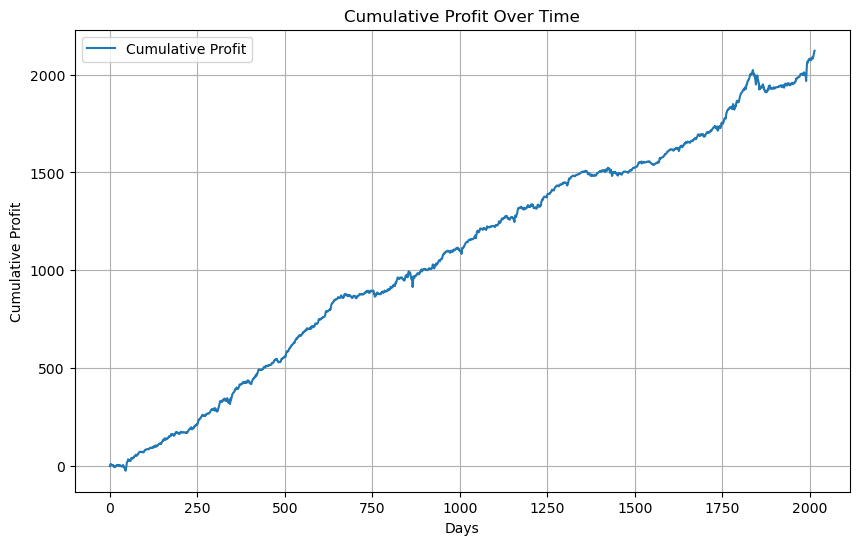

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(results['cumulative_profit'], label="Cumulative Profit")
plt.title("Cumulative Profit Over Time")
plt.xlabel("Days")
plt.ylabel("Cumulative Profit")
plt.legend()
plt.grid()
plt.show()

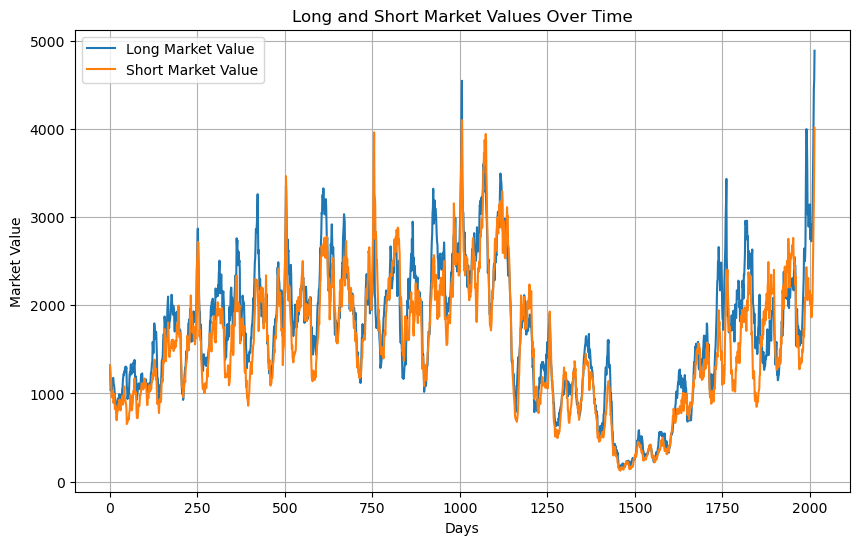

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(results['long_market_values'], label="Long Market Value")
plt.plot(results['short_market_values'], label="Short Market Value")
plt.title("Long and Short Market Values Over Time")
plt.xlabel("Days")
plt.ylabel("Market Value")
plt.legend()
plt.grid()
plt.show()

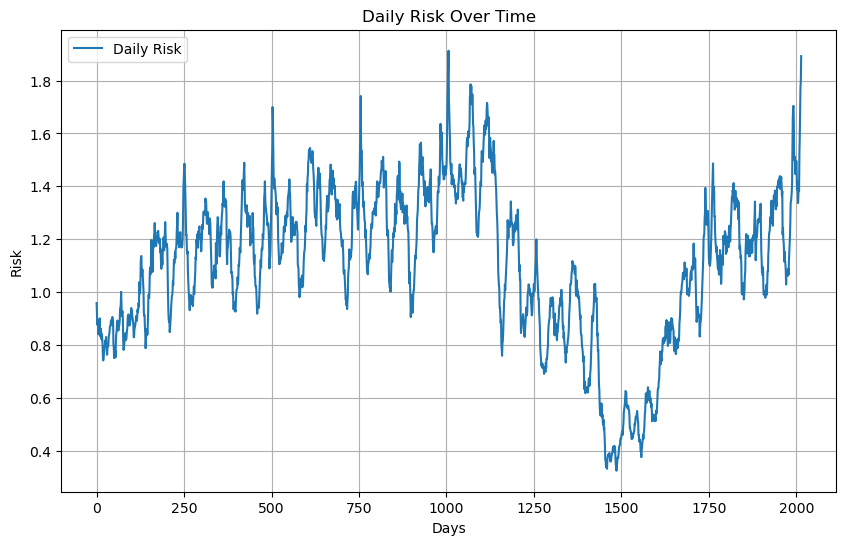

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(results['daily_risks'], label="Daily Risk")
plt.title("Daily Risk Over Time")
plt.xlabel("Days")
plt.ylabel("Risk")
plt.legend()
plt.grid()
plt.show()

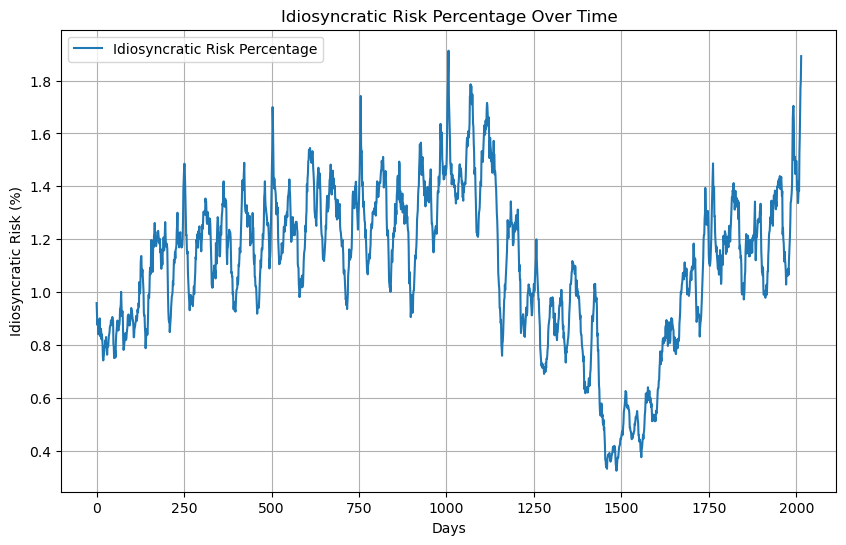

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(results['idiosyncratic_risks'], label="Idiosyncratic Risk Percentage")
plt.title("Idiosyncratic Risk Percentage Over Time")
plt.xlabel("Days")
plt.ylabel("Idiosyncratic Risk (%)")
plt.legend()
plt.grid()
plt.show()